# Data preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sktime.datatypes import convert_to
from sktime.datatypes._panel._convert import (
    from_3d_numpy_to_nested,
    from_3d_numpy_to_multi_index,
    from_multi_index_to_nested
)

%matplotlib inline

## Load the dataset

Data source: https://archive.ics.uci.edu/ml/datasets/Condition+monitoring+of+hydraulic+systems

In [2]:
data_path = "../data/Predictive-Maintenance-Of-Hydraulics-System/"

In [8]:
fs1 = np.loadtxt((data_path+'FS1.txt'), delimiter='\t')
fs1.shape

(2205, 600)

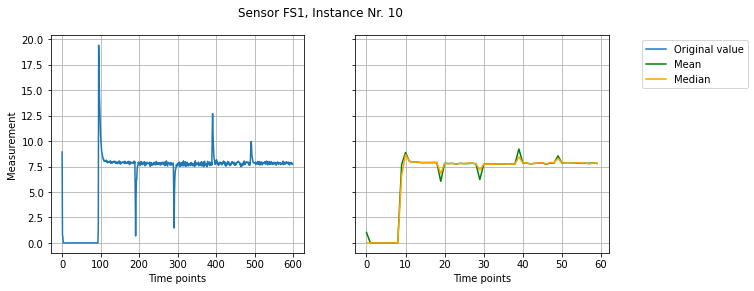

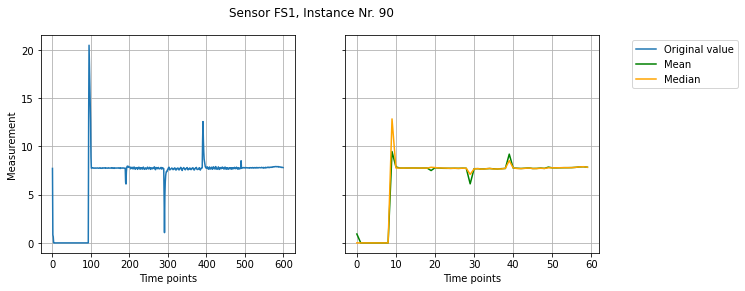

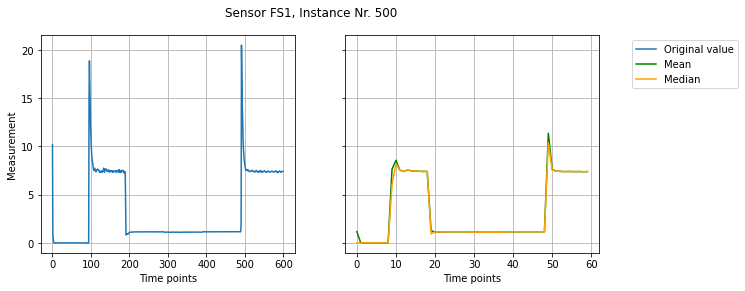

In [432]:
def plot_samples(file_name, instances=[0,1,2]):
    data = np.loadtxt((data_path+file_name), delimiter='\t')
    sensor_name = file_name.split('.')[0]
    
    for INSTANCE_NR in instances:
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
        for ax in ax1, ax2:
            ax.grid(True)

        ax1.plot(data[INSTANCE_NR], label="Original value")
        ax1.set_xlabel('Time points')
        ax1.set_ylabel('Measurement')


        avg = np.mean(data[INSTANCE_NR].reshape(60,10), axis=1)
        med = np.median(data[INSTANCE_NR].reshape(60,10), axis=1)

        ax2.plot(avg, label='Mean', color='green')
        ax2.plot(med, label='Median', color='orange')
        fig.suptitle(f'Sensor {sensor_name}, Instance Nr. {INSTANCE_NR}')
        ax2.set_xlabel('Time points')

        fig.legend(bbox_to_anchor=(1.1, 0.88))
        plt.show()

plot_samples('FS1.txt', [10, 90, 500])

## Data preprocessing

In [267]:
def read_data(file_path, delimiter='\t'):
    return np.loadtxt(file_path, delimiter=delimiter)

def reshape_data(data, new_len):
    return data.reshape(data.shape[0], new_len, int(data.shape[1]/new_len))

def calc_mean(data, axis=2):
    return np.mean(data, axis=axis)

In [ ]:
import glob 
import os

data_path = "../data/Predictive-Maintenance-Of-Hydraulics-System/"
file_names = []

for file_name_relative in glob.glob(data_path + "**/*.txt",recursive=True):
    file_name_absolute = os.path.basename(file_name_relative)
    file_names.append(file_name_absolute)
    
    # print("File name: ", file_name_absolute)

In [276]:
file_names.remove('description.txt')
file_names.remove('profile.txt')
file_names.remove('documentation.txt')

print(file_names)

['TS4.txt', 'TS1.txt', 'TS2.txt', 'PS6.txt', 'PS1.txt', 'PS5.txt', 'SE.txt', 'PS3.txt', 'TS3.txt', 'VS1.txt', 'CP.txt', 'CE.txt', 'PS4.txt', 'FS2.txt', 'FS1.txt', 'PS2.txt', 'EPS1.txt']


In [323]:
%%time

MIN_LENGTH = 60
stacked = None

for file_name in file_names:
    data = read_data((data_path + file_name))
    if data.shape[1] > MIN_LENGTH:
        data = reshape_data(data, MIN_LENGTH)
    else:
        data = reshape_data(data, 1)
    
    if data.shape[1] > 1:
        data = calc_mean(data)
        data = reshape_data(data, 1)
    
    if stacked is None:
        stacked = data
    else:
        stacked = np.column_stack((stacked, data))

stacked.shape

CPU times: user 1min 3s, sys: 8.26 s, total: 1min 11s
Wall time: 1min 11s


(2205, 17, 60)

## Save the numpy3D file

In [325]:
with open(data_path + 'preprocessed.npy', 'wb') as f:
    np.save(f, stacked)

## Convert the numpy3D into pandas multiindex dataframe

In [329]:
stacked.shape

(2205, 17, 60)

In [331]:
df = convert_to(stacked, to_type="pd-multiindex")
df.head()

var_0   var_1   var_2    var_3     var_4    var_5  \
instances timepoints                                                       
0         0           30.363  35.570  40.961  9.84138  176.8996  9.96442   
          1           30.375  35.492  40.949  9.83686  184.6420  9.95969   
          2           30.367  35.469  40.965  9.83819  189.8996  9.96422   
          3           30.367  35.422  40.922  9.84618  191.3442  9.96867   
          4           30.379  35.414  40.879  9.84887  191.2833  9.97288   

                       var_6    var_7   var_8  var_9  var_10  var_11  var_12  \
instances timepoints                                                           
0         0           68.039  0.18954  38.320  0.604   2.184  47.202     0.0   
          1            0.000  0.00000  38.332  0.605   2.184  47.273     0.0   
          2            0.000  0.00000  38.320  0.611   2.184  47.250     0.0   
          3            0.000  0.00000  38.324  0.603   2.185  47.332     0.0   
          4            0.000  0.00000  38.332  0.608   2.178  47.213     0.0   

                       var_13  var_14    var_15    var_16  
instances timepoints                                       
0         0           10.1691  1.0413  11.86685  2613.468  
          1           10.1704  0.0007   0.18786  2917.282  
          2           10.1641  0.0023   0.02133  2861.840  
          3           10.1751  0.0008   0.00283  2946.474  
          4           10.1730  0.0014   0.00000  2946.164

## Save the dataset as csv file

In [337]:
column_names = list(map(lambda x: x.split('.')[0], file_names))
df.columns = column_names

In [338]:
df.head()

TS4     TS1     TS2      PS6       PS1      PS5  \
instances timepoints                                                       
0         0           30.363  35.570  40.961  9.84138  176.8996  9.96442   
          1           30.375  35.492  40.949  9.83686  184.6420  9.95969   
          2           30.367  35.469  40.965  9.83819  189.8996  9.96422   
          3           30.367  35.422  40.922  9.84618  191.3442  9.96867   
          4           30.379  35.414  40.879  9.84887  191.2833  9.97288   

                          SE      PS3     TS3    VS1     CP      CE  PS4  \
instances timepoints                                                       
0         0           68.039  0.18954  38.320  0.604  2.184  47.202  0.0   
          1            0.000  0.00000  38.332  0.605  2.184  47.273  0.0   
          2            0.000  0.00000  38.320  0.611  2.184  47.250  0.0   
          3            0.000  0.00000  38.324  0.603  2.185  47.332  0.0   
          4            0.000  0.00000  38.332  0.608  2.178  47.213  0.0   

                          FS2     FS1       PS2      EPS1  
instances timepoints                                       
0         0           10.1691  1.0413  11.86685  2613.468  
          1           10.1704  0.0007   0.18786  2917.282  
          2           10.1641  0.0023   0.02133  2861.840  
          3           10.1751  0.0008   0.00283  2946.474  
          4           10.1730  0.0014   0.00000  2946.164

In [339]:
df.to_csv(data_path + 'preprocessed.csv')

## Read multiindex csv file into a pandas dataframe

In [3]:
# Check out if it works properly
data_path = "../data/Predictive-Maintenance-Of-Hydraulics-System/"
df2 = pd.read_csv(data_path + 'preprocessed.csv', index_col=[0,1])
df2.head()

TS4     TS1     TS2      PS6       PS1      PS5  \
instances timepoints                                                       
0         0           30.363  35.570  40.961  9.84138  176.8996  9.96442   
          1           30.375  35.492  40.949  9.83686  184.6420  9.95969   
          2           30.367  35.469  40.965  9.83819  189.8996  9.96422   
          3           30.367  35.422  40.922  9.84618  191.3442  9.96867   
          4           30.379  35.414  40.879  9.84887  191.2833  9.97288   

                          SE      PS3     TS3    VS1     CP      CE  PS4  \
instances timepoints                                                       
0         0           68.039  0.18954  38.320  0.604  2.184  47.202  0.0   
          1            0.000  0.00000  38.332  0.605  2.184  47.273  0.0   
          2            0.000  0.00000  38.320  0.611  2.184  47.250  0.0   
          3            0.000  0.00000  38.324  0.603  2.185  47.332  0.0   
          4            0.000  0.00000  38.332  0.608  2.178  47.213  0.0   

                          FS2     FS1       PS2      EPS1  
instances timepoints                                       
0         0           10.1691  1.0413  11.86685  2613.468  
          1           10.1704  0.0007   0.18786  2917.282  
          2           10.1641  0.0023   0.02133  2861.840  
          3           10.1751  0.0008   0.00283  2946.474  
          4           10.1730  0.0014   0.00000  2946.164

## Save the target variables into csv file

In [352]:
target_columns = ['target_cooler_condition', 'target_valve_condition', 'target_internal_pump_leakage', 
                  'target_hydraulic_accumulator_pressure', 'target_stable_flag']

profile = np.loadtxt((data_path + 'profile.txt'), delimiter='\t')
profile = profile.astype(int)
profile = profile.astype(str)

profile = pd.DataFrame(profile, columns=target_columns)

profile.head()

,target_cooler_condition,target_valve_condition,target_internal_pump_leakage,target_hydraulic_accumulator_pressure,target_stable_flag
0,3,100,0,130,1
1,3,100,0,130,1
2,3,100,0,130,1
3,3,100,0,130,1
4,3,100,0,130,1


In [353]:
profile.to_csv(data_path + 'profile_targets.csv', index=False)

## Read targets profile

In [3]:
profile = pd.read_csv(data_path + 'profile_targets.csv')
profile.head()

,target_cooler_condition,target_valve_condition,target_internal_pump_leakage,target_hydraulic_accumulator_pressure,target_stable_flag
0,3,100,0,130,1
1,3,100,0,130,1
2,3,100,0,130,1
3,3,100,0,130,1
4,3,100,0,130,1


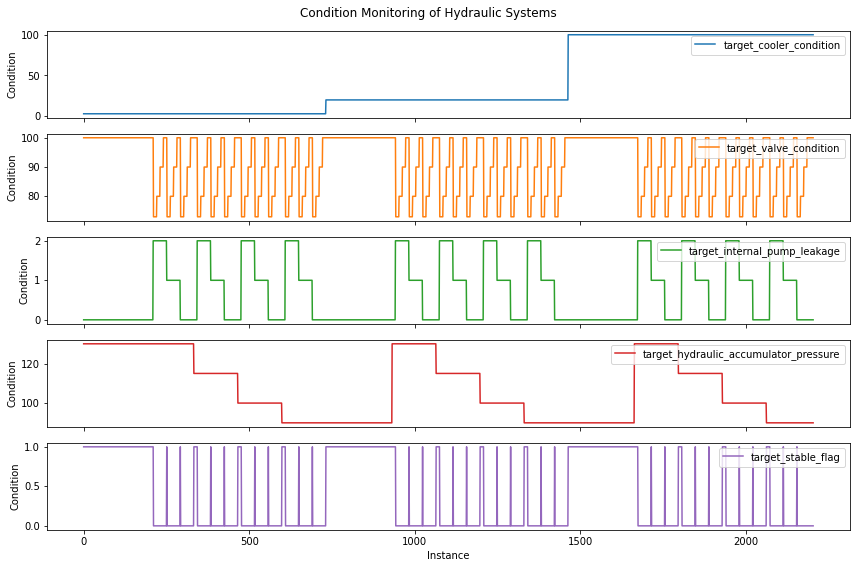

In [26]:
profile.plot(subplots=True, 
             figsize=(12, 8), 
             xlabel='Instance', 
             ylabel='Condition', 
             title='Condition Monitoring of Hydraulic Systems')

plt.tight_layout()
plt.show()

The target condition values are cycle-wise annotated in "profile.txt" (tab-delimited). As before, the row number represents the cycle number. 

The columns are:
```
1: Cooler condition / %:
	3: close to total failure
	20: reduced effifiency
	100: full efficiency

2: Valve condition / %:
	100: optimal switching behavior
	90: small lag
	80: severe lag
	73: close to total failure

3: Internal pump leakage:
	0: no leakage
	1: weak leakage
	2: severe leakage

4: Hydraulic accumulator / bar:
	130: optimal pressure
	115: slightly reduced pressure
	100: severely reduced pressure
	90: close to total failure

5: stable flag:
	0: conditions were stable
	1: static conditions might not have been reached yet
```

## Save the pandas dataframe in ts file format

In [9]:
df_nested = from_multi_index_to_nested(multi_ind_dataframe=df2, instance_index='instances')
df_nested.head()

,TS4,TS1,TS2,PS6,PS1,PS5,SE,PS3,TS3,VS1,CP,CE,PS4,FS2,FS1,PS2,EPS1
0,0 30.363 1 30.375 2 30.367 3 3...,0 35.570 1 35.492 2 35.469 3 3...,0 40.961 1 40.949 2 40.965 3 4...,0 9.84138 1 9.83686 2 9.83819 3 ...,0 176.8996 1 184.6420 2 189.8996 3...,0 9.96442 1 9.95969 2 9.96422 3 ...,0 68.039 1 0.000 2 0.000 3 ...,0 0.18954 1 0.00000 2 0.00000 3 ...,0 38.320 1 38.332 2 38.320 3 3...,0 0.604 1 0.605 2 0.611 3 0.60...,0 2.184 1 2.184 2 2.184 3 2.18...,0 47.202 1 47.273 2 47.250 3 4...,0 0.0 1 0.0 2 0.0 3 0.0 4 ...,0 10.1691 1 10.1704 2 10.1641 3 ...,0 1.0413 1 0.0007 2 0.0023 3 0...,0 11.86685 1 0.18786 2 0.0213...,0 2613.468 1 2917.282 2 2861.840 3...
1,0 33.648 1 33.723 2 33.723 3 3...,0 36.156 1 36.094 2 35.992 3 3...,0 41.258 1 41.277 2 41.262 3 4...,0 9.60095 1 9.59831 2 9.58497 3 ...,0 174.2707 1 191.3529 2 191.3024 3...,0 9.71038 1 9.70451 2 9.69738 3 ...,0 68.264 1 0.000 2 0.000 3 ...,0 0.18663 1 0.00000 2 0.00000 3 ...,0 38.680 1 38.672 2 38.668 3 3...,0 0.590 1 0.610 2 0.626 3 0.62...,0 1.414 1 1.384 2 1.385 3 1.38...,0 29.208 1 28.822 2 28.805 3 2...,0 0.0 1 0.0 2 0.0 3 0.0 4 ...,0 10.4113 1 10.4047 2 10.3989 3 ...,0 1.0458 1 0.0024 2 0.0006 3 0...,0 12.28756 1 0.22033 2 0.0241...,0 2582.128 1 2939.828 2 2944.482 3...
2,0 35.113 1 35.121 2 35.098 3 3...,0 37.488 1 37.391 2 37.340 3 3...,0 42.129 1 42.105 2 42.117 3 4...,0 9.49861 1 9.48868 2 9.47973 3 ...,0 174.0188 1 191.2384 2 191.2183 3...,0 9.60278 1 9.59102 2 9.58121 3 ...,0 68.595 1 0.000 2 0.000 3 ...,0 0.17820 1 0.00000 2 0.00000 3 ...,0 39.234 1 39.246 2 39.246 3 3...,0 0.578 1 0.603 2 0.638 3 0.65...,0 1.159 1 1.157 2 1.157 3 1.13...,0 23.554 1 23.521 2 23.527 3 2...,0 0.0 1 0.0 2 0.0 3 0.0 4 ...,0 10.4085 1 10.4089 2 10.3852 3 ...,0 1.0418 1 0.0019 2 0.0006 3 0...,0 11.82779 1 0.14628 2 0.0004...,0 2569.696 1 2928.872 2 2934.702 3...
3,0 36.133 1 36.105 2 36.113 3 3...,0 38.633 1 38.535 2 38.469 3 3...,0 43.039 1 43.043 2 43.039 3 4...,0 9.39844 1 9.39801 2 9.39616 3 ...,0 173.6540 1 191.1975 2 191.1919 3...,0 9.49866 1 9.50204 2 9.49797 3 ...,0 68.628 1 0.000 2 0.000 3 ...,0 0.18782 1 0.00000 2 0.00000 3 ...,0 40.086 1 40.047 2 40.102 3 4...,0 0.565 1 0.591 2 0.608 3 0.61...,0 1.101 1 1.086 2 1.107 3 1.07...,0 21.540 1 21.419 2 21.565 3 2...,0 0.0 1 0.0 2 0.0 3 0.0 4 ...,0 10.3430 1 10.3406 2 10.3452 3 ...,0 1.0381 1 0.0001 2 0.0022 3 0...,0 11.51406 1 0.03499 2 0.0000...,0 2557.660 1 2922.246 2 2927.978 3...
4,0 36.992 1 37.004 2 37.008 3 3...,0 39.461 1 39.461 2 39.375 3 3...,0 44.031 1 44.027 2 43.988 3 4...,0 9.29771 1 9.30610 2 9.30532 3 ...,0 173.4353 1 191.2045 2 191.1586 3...,0 9.40144 1 9.40599 2 9.40559 3 ...,0 68.868 1 0.000 2 0.000 3 ...,0 0.17860 1 0.00000 2 0.00000 3 ...,0 40.934 1 40.922 2 40.922 3 4...,0 0.570 1 0.600 2 0.623 3 0.63...,0 1.086 1 1.081 2 1.087 3 1.06...,0 20.460 1 20.298 2 20.350 3 1...,0 0.0 1 0.0 2 0.0 3 0.0 4 ...,0 10.2800 1 10.2826 2 10.2827 3 ...,0 0.9909 1 0.0009 2 0.0017 3 0...,0 12.29913 1 0.13083 2 0.0129...,0 2546.404 1 2913.798 2 2920.364 3...


In [10]:
df_nested.shape

(2205, 17)

In [25]:
from sktime.datasets._data_io import write_dataframe_to_tsfile
comment="Condition monitoring of hydraulic systems. Source: https://archive.ics.uci.edu/ml/datasets/Condition+monitoring+of+hydraulic+systems"

write_dataframe_to_tsfile(data=df_nested,
                          path=data_path,
                          problem_name='hydraulic-systems-monitoring',
                          class_label=profile['target_cooler_condition'].unique(),
                          class_value_list=profile['target_cooler_condition'].values,
                          equal_length=True,
                          series_length=len(df_nested.iloc[0,0]),
                          comment=comment
                         )

## Simple EDA on the preprocessed dataset

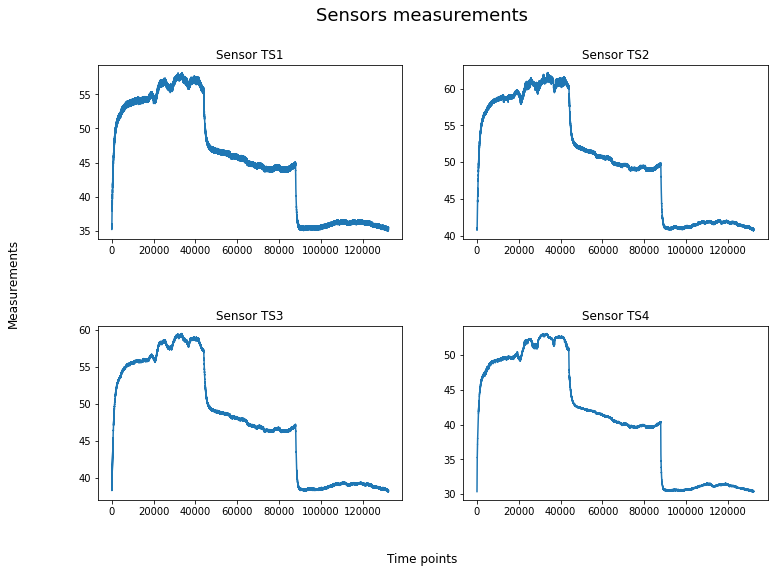

In [453]:
# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Sensors measurements", fontsize=18)
fig.supxlabel('Time points')
fig.supylabel('Measurements')
tickers = ['TS1', 'TS2', 'TS3', 'TS4']

# loop through tickers and axes
for ticker, ax in zip(tickers, axs.ravel()):
    # filter df for ticker and plot on specified axes
    ax.plot(df[ticker].values)
    # chart formatting
    ax.set_title(f'Sensor {ticker}')
    ax.set_xlabel("")

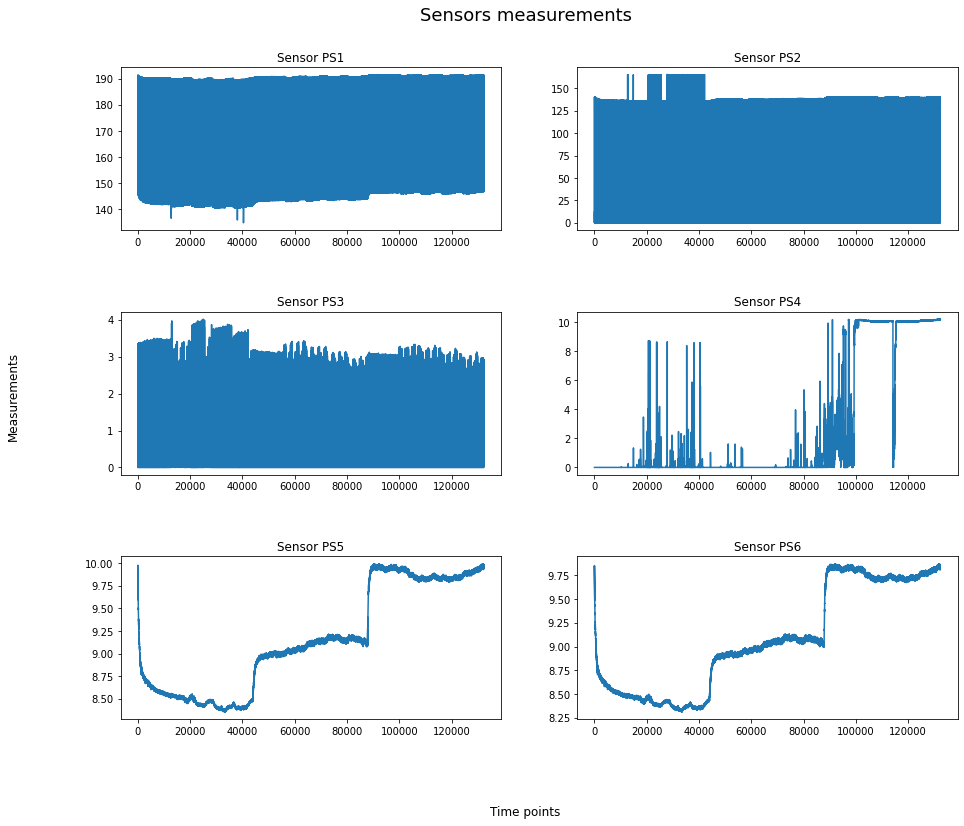

In [452]:
# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Sensors measurements", fontsize=18, y=0.95)
fig.supxlabel('Time points')
fig.supylabel('Measurements')
tickers = ['PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6']

# loop through tickers and axes
for ticker, ax in zip(tickers, axs.ravel()):
    # filter df for ticker and plot on specified axes
    ax.plot(df[ticker].values)
    # chart formatting
    ax.set_title(f'Sensor {ticker}')
    ax.set_xlabel("")

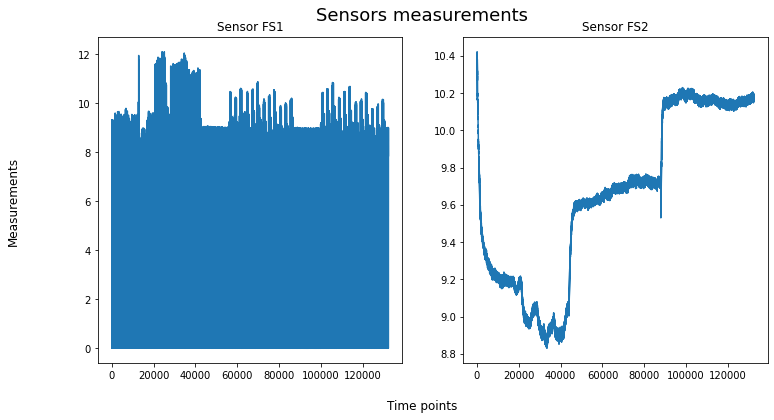

In [456]:
# define subplot grid
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Sensors measurements", fontsize=18, y=0.95)
fig.supxlabel('Time points')
fig.supylabel('Measurements')
tickers = ['FS1', 'FS2']

# loop through tickers and axes
for ticker, ax in zip(tickers, axs.ravel()):
    # filter df for ticker and plot on specified axes
    ax.plot(df[ticker].values)
    # chart formatting
    ax.set_title(f'Sensor {ticker}')
    ax.set_xlabel("")